# Modeling

## 1. SARIMA

In [2]:
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import itertools
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn import datasets, linear_model
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
plt.style.use('seaborn-deep')
import warnings
warnings.filterwarnings("ignore")

In [3]:
ts = pd.read_csv("cleaned-daily.csv", parse_dates = ['Date'])
ts = ts.set_index('Date')[["kWh"]].sort_index().asfreq('d')
ts.head(15)

,kWh
Date,
2017-01-01,399131.94
2017-01-02,545259.57
2017-01-03,557400.78
2017-01-04,557394.31
2017-01-05,554266.71
2017-01-06,484772.87
2017-01-07,448601.37
2017-01-08,433151.95
2017-01-09,638036.96


<AxesSubplot:xlabel='Date'>

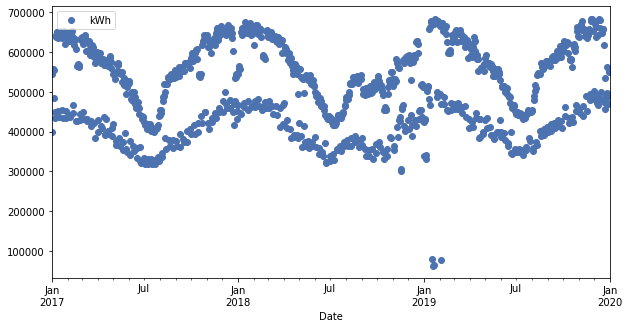

In [4]:
ts.plot(figsize=(10,5),style="o")

In [5]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=14, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts.kWh)

Results of Dickey-Fuller Test:
Test Statistic                   -2.519272
p-value                           0.110855
#Lags Used                       14.000000
Number of Observations Used    1081.000000
Critical Value (1%)              -3.436414
Critical Value (5%)              -2.864217
Critical Value (10%)             -2.568196
dtype: float64


<AxesSubplot:xlabel='Date'>

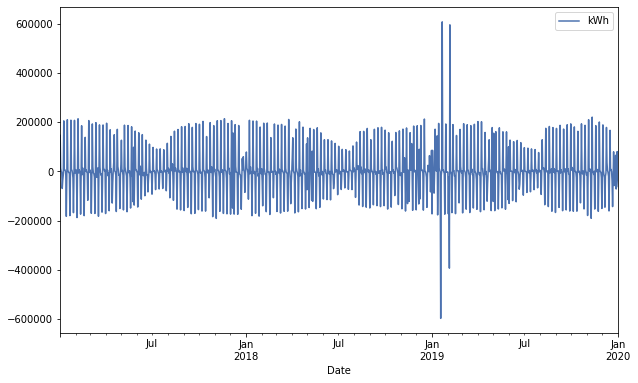

In [6]:
# invert differenced forecast
def invert_diff(series, first_element_before):
    cumsum = series.cumsum()
    return cumsum.fillna(0) + first_element_original

diffed = diff(ts,seasonal_periods=7)
diffed.plot(figsize=(10,6))

In [7]:
test_stationarity(diffed.kWh)

Results of Dickey-Fuller Test:
Test Statistic                -1.287184e+01
p-value                        4.860589e-24
#Lags Used                     1.400000e+01
Number of Observations Used    1.080000e+03
Critical Value (1%)           -3.436419e+00
Critical Value (5%)           -2.864220e+00
Critical Value (10%)          -2.568197e+00
dtype: float64


<AxesSubplot:xlabel='Date'>

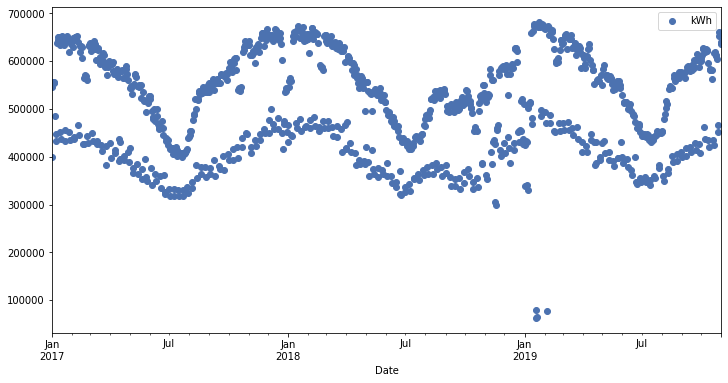

In [8]:
train_end = '2019-11-01'
test_end = '2019-12-01'
demo_start = '2019-10-25'
demo = ts[demo_start:test_end]
train,test,validation = ts[:train_end],\
                        ts[train_end:test_end],\
                        ts[test_end:]

train.plot(figsize=(12,6), style = 'o')

There is complex seasonality in play

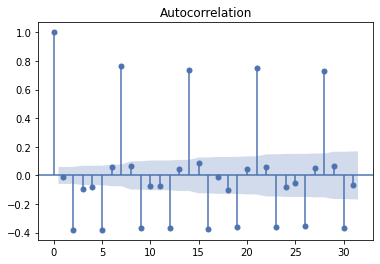

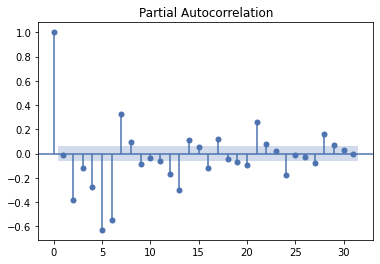

In [9]:
acf = plot_acf(diffed)
pacf = plot_pacf(diffed)

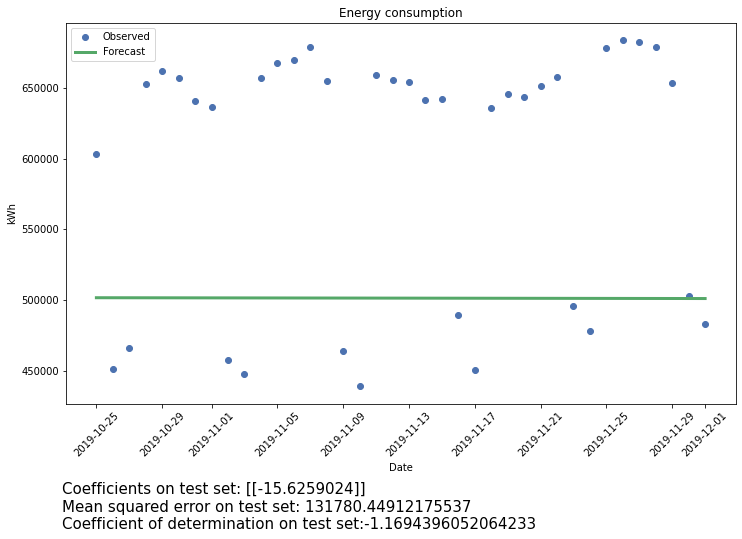

In [10]:
from math import sqrt

X = (train.index - train.index[0]).days.values.reshape(-1, 1)
y = train.kWh.values.reshape(-1, 1)

X_demo = (demo.index - train.index[0]).days.values.reshape(-1,1)
y_demo = demo.kWh.values.reshape(-1, 1)

X_test = (test.index - train.index[0]).days.values.reshape(-1,1)
y_test = test.kWh.values.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(X,y)

regr_pred_demo = regr.predict(X_demo)
regr_pred_test = regr.predict(X_test)

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', xlabel='Date', ylabel='kWh')

ax.plot(demo.index, y_demo,'o')
ax.plot(demo.index, regr_pred_demo, linewidth=3)

err = 'Coefficients on test set: ' + str(regr.coef_) + '\nMean squared error on test set: ' + \
    str(sqrt(MSE(y_test, regr_pred_test))) + '\nCoefficient of determination on test set:' + \
        str(r2_score(y_test, regr_pred_test))

plt.figtext(0.12, -0.08, err, ha="left",fontsize=15,va='center')
plt.xticks(rotation=45)
legend = ax.legend(["Observed", "Forecast"])




## Grid Search

In [ ]:
# SARIMA model pipeline
def sarimax(ts,param):
    try:
        mod = sm.tsa.statespace.SARIMAX(ts,
                                order=param[0],
                                seasonal_order=param[1])
        res = mod.fit(max_iter = 50, method = 'powell',disp=0)

        return res.aic,param,res
    except Exception as e:
        # in case of convergence errors, non-invertible errors, etc.
        print(f"##### Skipped modelling with: {param}\n")
        print(e)
        return float(inf),param,None

def par_sarimax(ts,all_param):
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
    all_res = []
    
    try:
        # call our function in a parallel manner
        tasks = (delayed(sarimax)(train, param) for param in all_param)  
        results = executor(tasks)

        all_res.append(results)
    except Exception as e:
        print('Fatal Error....')
        print(e)
    
    return all_res
    

# set parameter range
p,d,q = range(0,2),[1],range(0,2)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))


start = time.perf_counter()
all_res = par_sarimax(train,all_param)
finish = time.perf_counter()
print(f'Finished in {finish-start} second(s)')

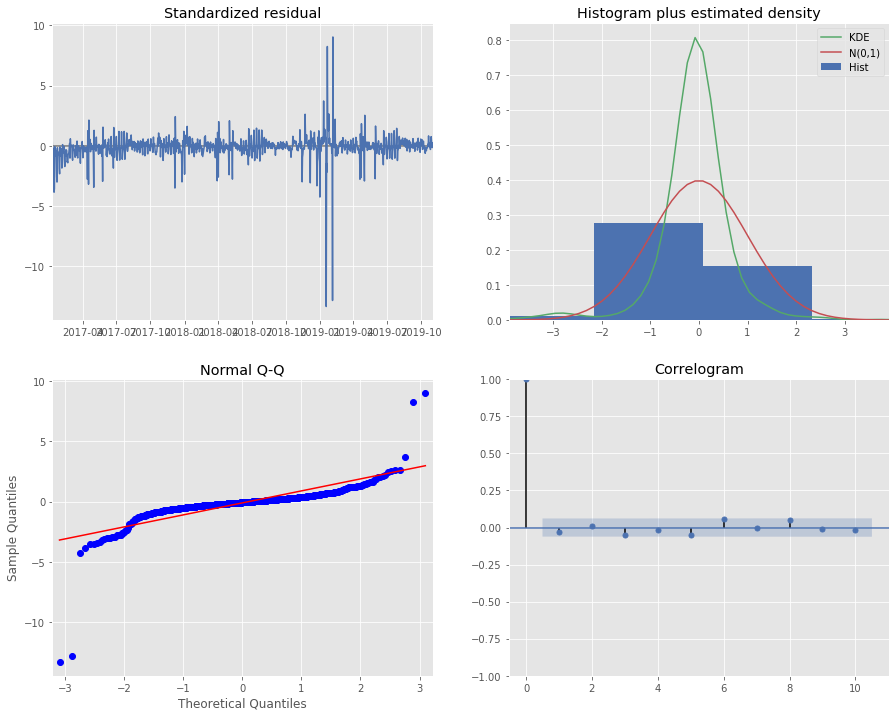

Ljung-box p-values:
[2.96138571e-01 5.37614708e-01 2.47208500e-01 3.58817529e-01
 2.16284488e-01 9.21282015e-02 1.42313696e-01 9.38507115e-02
 1.34051528e-01 1.71119012e-01 2.30416009e-01 2.97604013e-01
 3.70381400e-01 3.33784261e-01 1.59261397e-04 2.75106157e-04
 8.48675057e-14 4.05120805e-15 1.02139658e-14 2.49190234e-14
 1.49990723e-14 3.13135566e-14 6.91906400e-14 3.18618222e-14
 3.37634284e-15 4.21416899e-15 6.65994126e-15 1.10882042e-14
 1.46363509e-15 2.15112006e-15 4.52101829e-15 9.20060505e-15
 1.92116396e-14 1.28861869e-15 1.59904758e-15 3.27069006e-15
 3.65041677e-15 5.85510379e-15 1.11592541e-14 1.85771269e-14]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                               kWh   No. Observations:                 1035
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 7)   Log Likelihood              -12445.428
Date:                           Thu, 07 Jan 2021   AIC                          24900.856
Time:                                   15:45:36   BIC                          24925.528
Sample:                               01-01-2017   HQIC                         24910.220
                                    - 11-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4690      0.024     19.182      0.000       0.421       0.517
ma.L1         -0.8047      0.023    -34.592      0.000      -0.850      -0.759
ma.S.L7       -0.8930      0.016    -55.645      0.000      -0.924      -0.862
ma.S.L14      -0.1070      0.014     -7.448      0.000      -0.135      -0.079
sigma2      1.904e+09   7.87e-12   2.42e+20      0.000     1.9e+09     1.9e+09
===================================================================================
Ljung-Box (Q):                      148.92   Jarque-Bera (JB):            200256.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.21   Skew:                            -3.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        71.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.44e+35. Standard errors may be unstable.
"""

In [185]:
results.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(results.test_serial_correlation(method='ljungbox')[0][1]))
results.summary()

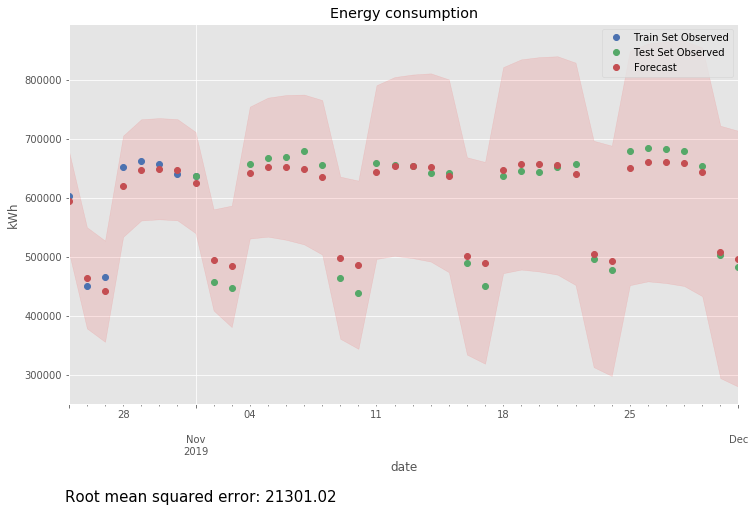

In [186]:
""" For demo only """
pred_test = results.get_prediction(start=train_end,end=test_end)

# The mean squared error
err = 'Root mean squared error: %.2f'% sqrt(MSE(test, pred_test.predicted_mean))

pred = results.get_prediction(start=demo_start,end=test_end)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', ylabel='kWh')

train[demo_start:].plot(ax=ax, style='o')
test.plot(ax=ax, style='o')
pred.predicted_mean.plot(ax=ax, style='o')
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])

# LSTM

## Feature Engineering

In [187]:
import IPython
import IPython.display

import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'